In [5]:
import pandas as pd

def carregar_instancia_dieta(csv_file):
    df = pd.read_csv(csv_file)

    alimentos = df['Alimento'].tolist()
    custo = dict(zip(df['Alimento'], df['Custo_por_100g']))
    min_porcoes = dict(zip(df['Alimento'], df['Minimo_porcao']))

    nutrientes = ['Proteina', 'Carboidrato', 'Vitamina']
    requisitos = {'Proteina': 70, 'Carboidrato': 250, 'Vitamina': 40}

    nutrition_values = {al: {nutr: df.loc[df['Alimento']==al, nutr].values[0] for nutr in nutrientes}
                        for al in alimentos}

    return alimentos, custo, min_porcoes, nutrientes, requisitos, nutrition_values


In [6]:
from pyomo.environ import ConcreteModel, Var, Objective, Constraint, SolverFactory, NonNegativeReals, minimize
import time

def resolver_dieta(alimentos, custo, min_porcoes, nutrientes, requisitos, nutrition_values):
    model = ConcreteModel()
    model.x = Var(alimentos, within=NonNegativeReals, bounds=lambda m, f: (min_porcoes[f], None))

    model.obj = Objective(expr=sum(custo[f] * model.x[f] for f in alimentos), sense=minimize)

    def nutrient_rule(model, nutr):
        return sum(nutrition_values[f][nutr] * model.x[f] for f in alimentos) >= requisitos[nutr]

    model.nutrient_constraints = Constraint(nutrientes, rule=nutrient_rule)

    solver = SolverFactory('glpk')
    start_time = time.time()
    resultado = solver.solve(model)
    elapsed_time = time.time() - start_time


    resultados_df = pd.DataFrame({
        'Alimento': alimentos,
        'Quantidade (porções 100g)': [round(model.x[f].value, 2) for f in alimentos],
        'Custo Total (R$)': [round(custo[f] * model.x[f].value, 2) for f in alimentos]
    })

    total_custo = resultados_df['Custo Total (R$)'].sum()

    return resultados_df, total_custo, elapsed_time


In [7]:
instancias = ['data/A1.csv', 'data/A2.csv', 'data/A3.csv', 'data/A4.csv']

comparativo_itens = []
comparativo_custo = []

for csv_file in instancias:
    alimentos, custo, min_porcoes, nutrientes, requisitos, nutrition_values = carregar_instancia_dieta(csv_file)
    resultados_df, total_custo, tempo = resolver_dieta(alimentos, custo, min_porcoes, nutrientes, requisitos, nutrition_values)

    print(f"\nResultados detalhados para {csv_file}:")
    print(resultados_df)
    print(f"Custo total: R$ {total_custo:.2f}\n")

    comparativo_itens.append({
        'Instancia': csv_file,
        'Num_alimentos': len(alimentos),
        'Custo_total': total_custo,
        'Tempo_segundos': tempo
    })

    comparativo_custo.append({
        'Instancia': csv_file,
        'Custo_total': total_custo,
        'Tempo_segundos': tempo
    })

df_comparativo_itens = pd.DataFrame(comparativo_itens)
df_comparativo_custo = pd.DataFrame(comparativo_custo)

print("\n=== Comparativo de alimentos selecionados ===")
display(df_comparativo_itens)

print("\n=== Comparativo do custo total da dieta ===")
display(df_comparativo_custo)



Resultados detalhados para data/A1.csv:
  Alimento  Quantidade (porções 100g)  Custo Total (R$)
0    arroz                       0.50              0.50
1   feijao                      25.93             46.67
2   frango                       0.50              3.50
3    leite                       0.30              1.05
4     maçã                       0.30              0.75
Custo total: R$ 52.47


Resultados detalhados para data/A2.csv:
  Alimento  Quantidade (porções 100g)  Custo Total (R$)
0    arroz                       0.50              0.50
1   feijao                      25.56             46.01
2   frango                       0.50              3.50
3    leite                       0.30              1.05
4     maçã                       0.30              0.75
5    carne                       0.50              5.00
6    peixe                       0.40              3.60
7      ovo                       0.20              1.20
8      pão                       0.30              0.84

,Instancia,Num_alimentos,Custo_total,Tempo_segundos
0,data/A1.csv,5,52.47,0.418826
1,data/A2.csv,10,62.90,0.471638
2,data/A3.csv,15,68.74,0.120100
3,data/A4.csv,20,69.44,0.093659



=== Comparativo do custo total da dieta ===


,Instancia,Custo_total,Tempo_segundos
0,data/A1.csv,52.47,0.418826
1,data/A2.csv,62.90,0.471638
2,data/A3.csv,68.74,0.120100
3,data/A4.csv,69.44,0.093659


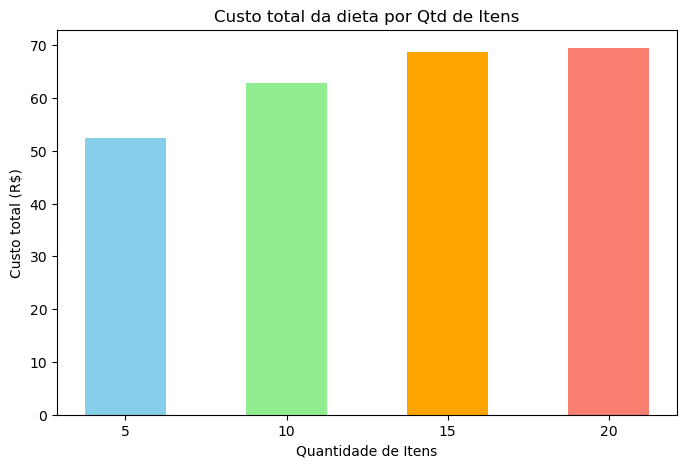

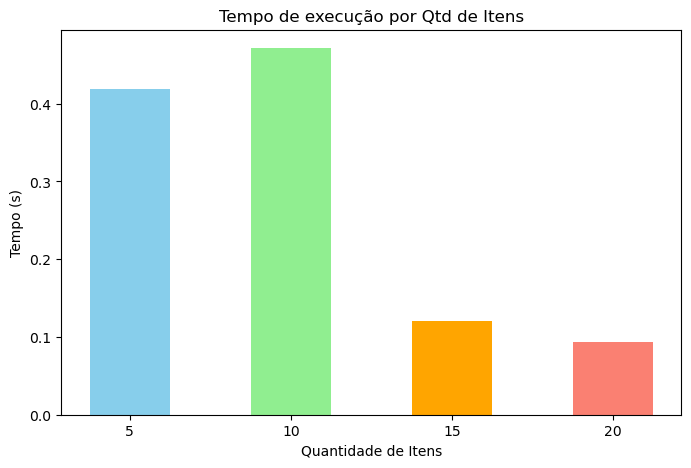

In [8]:
import matplotlib.pyplot as plt

instancias_valor = [1, 2, 3, 4]  # A1, A2, A3, A4
cores = ['skyblue', 'lightgreen', 'orange', 'salmon']
largura_barra = 0.5

plt.figure(figsize=(8,5))
plt.bar(instancias_valor, df_comparativo_custo['Custo_total'], color=cores, width=largura_barra)
plt.title('Custo total da dieta por Qtd de Itens')
plt.xlabel('Quantidade de Itens')
plt.ylabel('Custo total (R$)')
plt.xticks(instancias_valor, ['5','10','15','20'])
plt.show()

plt.figure(figsize=(8,5))
plt.bar(instancias_valor, df_comparativo_custo['Tempo_segundos'], color=cores, width=largura_barra)
plt.title('Tempo de execução por Qtd de Itens')
plt.xlabel('Quantidade de Itens')
plt.ylabel('Tempo (s)')
plt.xticks(instancias_valor, ['5','10','15','20'])
plt.show()
